In [2]:
from pathlib import Path
from pandas import DataFrame
import pandas as pd
import numpy as np
import sklearn

sklearn.set_config(display="diagram")
sklearn.set_config(transform_output = "pandas")

def load_movie_data():
    return pd.read_csv(Path("data/movie_dataset.csv"))

def prepare_movie_data(data: DataFrame):
    filtered: DataFrame = data.dropna().loc[~(data == 0).any(axis=1)]
    filtered.set_index('index')
    return filtered


movie_df = prepare_movie_data(load_movie_data())

movie_df


,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton
5,5,258000000,Fantasy Action Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity amnesia sandstorm love of one's ...,en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,Tobey Maguire Kirsten Dunst James Franco Thoma...,"[{'name': 'Francine Maisler', 'gender': 1, 'de...",Sam Raimi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752,4752,65000,Romance Comedy Drama,http://tinyfurniture.com/,47607,sister sister relationship male female relatio...,en,Tiny Furniture,"After graduating from film school, Aura return...",2.380332,...,99.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Aura would like you to know that she is having...,Tiny Furniture,5.6,59,Lena Dunham Laurie Simmons Grace Dunham Rachel...,"[{'name': 'Lena Dunham', 'gender': 1, 'departm...",Lena Dunham
4758,4758,4000000,Thriller Science Fiction,https://www.facebook.com/thesignalfilm,242095,hacker supernatural powers road trip independe...,en,The Signal,Three college students on a road trip across t...,27.662696,...,95.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,R U Agitated?,The Signal,5.8,631,Brenton Thwaites Olivia Cooke Beau Knapp Laure...,"[{'name': 'Mary Vernieu', 'gender': 1, 'depart...",William Eubank
4772,4772,31192,Drama Action Comedy,http://downterrace.blogspot.com/,42151,murder dark comedy crime family,en,Down Terrace,After serving jail time for a mysterious crime...,1.330379,...,89.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,You're only as good as the people you know.,Down Terrace,6.3,26,Robert Hill Robin Hill Julia Deakin David Scha...,"[{'name': 'Ben Wheatley', 'gender': 2, 'depart...",Ben Wheatley
4773,4773,27000,Comedy,http://www.miramax.com/movie/clerks/,2292,salescle

,budget,genres,runtime,vote_average,popularity,vote_count
425,80000000,Adventure Action Thriller,110.0,6.7,75.290998,2631
928,50000000,Drama,133.0,7.0,46.180421,1381
397,85000000,Comedy Romance,121.0,6.2,16.479851,360
216,120000000,Adventure Drama Action,127.0,7.2,51.328145,5797
1235,40000000,Drama Romance,135.0,6.7,10.433667,155
...,...,...,...,...,...,...
1695,28000000,Animation Family Comedy Adventure Fantasy,90.0,7.4,92.982009,3416
495,79000000,Adventure Action Science Fiction,94.0,5.8,40.723459,1030
155,100000000,Comedy,90.0,5.9,25.159168,627
598,75000000,Comedy Drama Music Romance,123.0,6.0,23.515938,385


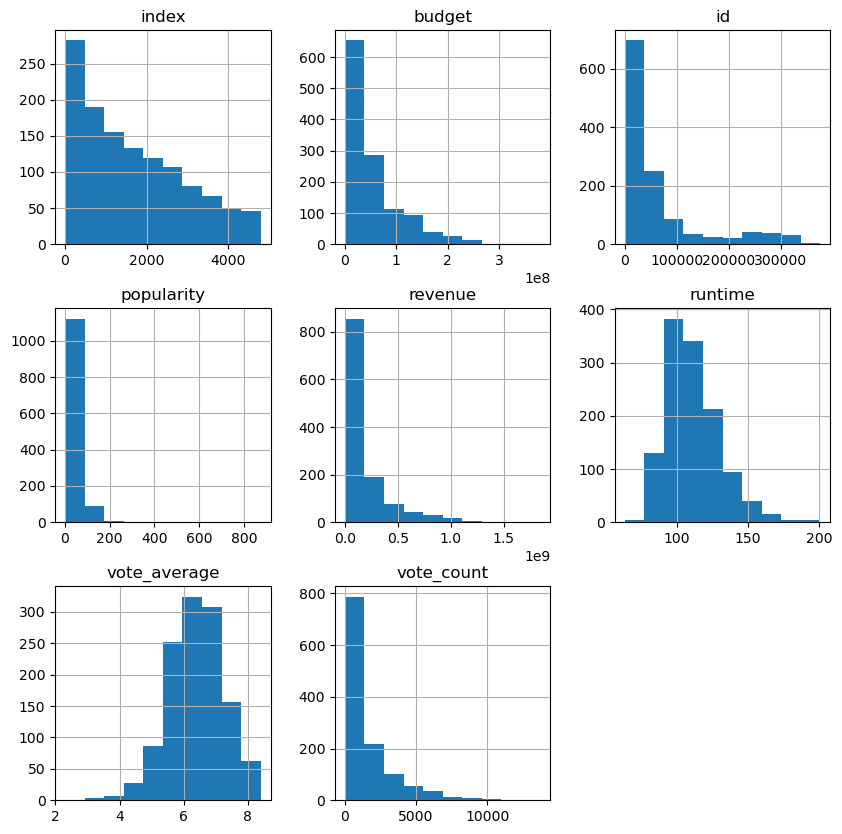

In [3]:

from sklearn.model_selection import train_test_split

def add_budget_cat_column():
    bincount = 5
    bins = np.append(np.linspace(0., 1e8, bincount), [np.inf])
    labels = np.arange(1, bincount + 1)
    movie_df['budget_cat'] = pd.cut(movie_df['budget'], bins=bins, labels=labels)

def drop_budget_cat_column(dfs: list[DataFrame]):
    for train_set in dfs:
        train_set.drop(columns=['budget_cat'], inplace=True)

movie_df.hist(figsize=(10,10))

add_budget_cat_column()

training_df: DataFrame
testing_df: DataFrame
training_df, testing_df = train_test_split(movie_df, test_size=0.2, stratify=movie_df['budget_cat'], random_state=42)

drop_budget_cat_column([training_df, testing_df])

def get_train_and_label(data: DataFrame) -> tuple[DataFrame, DataFrame]:
    feature_attributes = ['budget', 'genres', 'runtime', 'vote_average', 'popularity', 'vote_count']
    label_attributes = ['revenue']
    return data[feature_attributes].copy(), data[label_attributes].copy()

train_df, label_df = get_train_and_label(training_df)

train_df

In [4]:
from sklearn.base import TransformerMixin, BaseEstimator
from pandas import Series

class NaFiller(BaseEstimator, TransformerMixin):
    def __init__(self, replacement):
        self.replacement = replacement

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X: DataFrame):
        return X.fillna(self.replacement)

class SeparatorSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, sep = ' '):
        self.sep = sep

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, XX: DataFrame):
        X = XX.copy()
        for column in X.columns:
            X[column] =[v.split(self.sep) for v in X[column]]
        return X

class ListExpander(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.classes = []

    def fit(self, X: DataFrame, y=None, **fit_params):
        self.classes = []
        for column in X.columns:
            values: Series = X[column]
            feat_classes = set()
            for x in values:
                feat_classes = feat_classes | set(x)
            self.classes.append((column, list(feat_classes)))
        return self

    def transform(self, XX: DataFrame):
        X = XX.copy()
        # all_classes = [cl for _, cl in self.classes][0]
        for (column, classes) in self.classes:
            rows = []
            for array in X[column]:
                single_feature_row = []
                for c in classes:
                    if c in array:
                        single_feature_row.append(1)
                    else:
                        single_feature_row.append(0)
                rows.append(single_feature_row)
            for idx, c in enumerate(classes):
                X[c] = np.transpose(rows)[idx]
            X.drop(columns = [column], inplace=True)
        return X


,num__budget,num__runtime,num__vote_average,num__popularity,num__vote_count,genre__Drama,genre__Mystery,genre__War,genre__Family,genre__Science,...,genre__Fiction,genre__Fantasy,genre__Animation,genre__Crime,genre__Western,genre__Horror,genre__Music,genre__Adventure,genre__History,genre__Foreign
425,18.197537,4.700480,1.902108,4.321361,7.875119,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
928,17.727534,4.890349,1.945910,3.832556,7.230563,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397,18.258162,4.795791,1.824549,2.802138,5.886104,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216,18.603002,4.844187,1.974081,3.938239,8.665096,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1235,17.504390,4.905275,1.902108,2.345038,5.043425,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,17.147715,4.499810,2.001480,4.532406,8.136226,0,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
495,18.184958,4.543295,1.757858,3.706804,6.937314,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
155,18.420681,4.499810,1.774952,3.225222,6.440947,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,18.132999,4.812184,1.791759,3.157678,5.953243,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


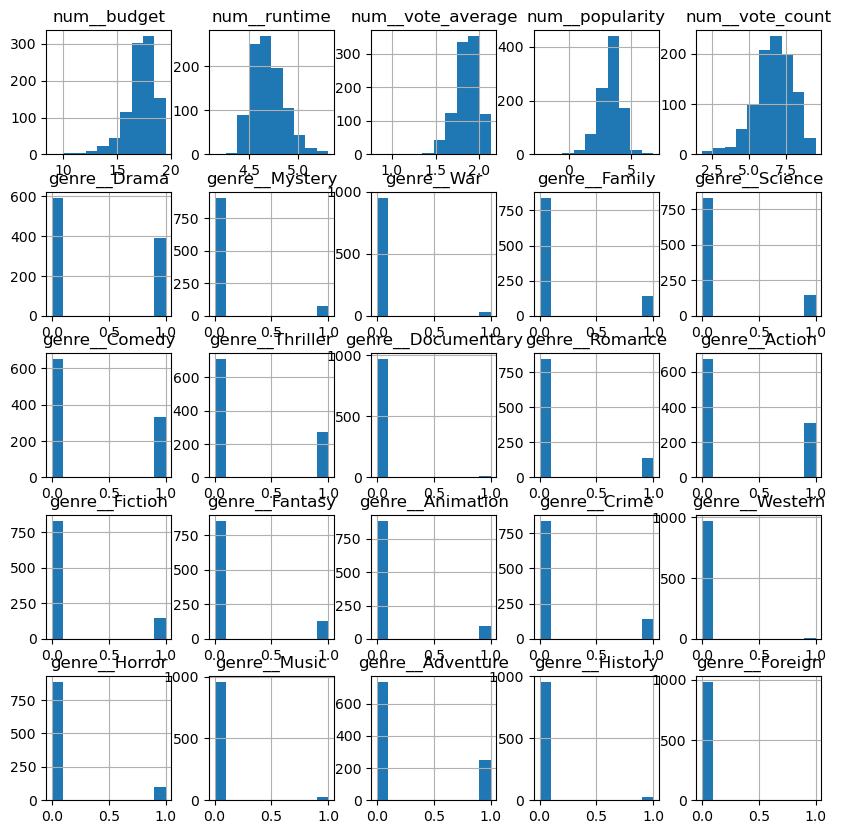

In [5]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def make_preprocessing():
    num_attribs = ['budget', 'runtime', 'vote_average', 'popularity', 'vote_count']
    cat_attribs = ['genres']

    genre_pipeline = make_pipeline(
        NaFiller(''),
        SeparatorSplitter(),
        ListExpander()
    )

    num_pipeline = make_pipeline(
        FunctionTransformer(np.log, np.exp)
    )

    return ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('genre', genre_pipeline, cat_attribs)
    ])

preprocessing = make_preprocessing()

feature_prepared = preprocessing.fit_transform(train_df, label_df)

feature_prepared.hist(figsize=(10, 10))
feature_prepared


In [6]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
# tree_reg = DecisionTreeRegressor(random_state=42)
# tree_reg.fit(feature_prepared, label_df)

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(feature_prepared, label_df.values.ravel())
# lin_reg = LinearRegression()
# lin_reg.fit(feature_prepared, label_df)



ValueError: A given column is not a column of the dataframe

In [ ]:

from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, feature_prepared, label_df, scoring='neg_root_mean_squared_error', cv=10)

tree_rmses


In [ ]:

from sklearn.model_selection import cross_val_score

forest_rmses: np.ndarray = -cross_val_score(forest_reg, feature_prepared, label_df.values.ravel(), scoring='neg_root_mean_squared_error', cv=10)

pd.Series(forest_rmses).describe()


In [ ]:
from sklearn.metrics import mean_squared_error
# revenue_predicted = tree_reg.predict(feature_prepared)
revenue_predicted = lin_reg.predict(feature_prepared)
err = mean_squared_error(label_df, revenue_predicted, squared=False)
err
# feature_prepared.hist(figsize=(10,10))
